<a href="https://colab.research.google.com/github/swshadle/physics/blob/master/Gaia_Clusters_HR_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Retrieving Clusters from Gaia with Hertzsprung-Russell Diagram

Learn how to retrieve [Gaia mission](https://sci.esa.int/web/gaia) data from within Google Colab. In this lab, we'll retrieve apparent brightness, location in the night sky (right ascension and declination), distance from earth, and color (how red or blue) information for one particular one star cluster, [the Pleiades](https://en.wikipedia.org/wiki/Pleiades). We'll also use the tools of astrophysics to calculate absolute magnitude, luminosity, surface temperature, and size from the Gaia-supplied data.

Partially based on [Gaia Python Tutorial: Cluster Analysis](https://gea.esac.esa.int/archive-help/tutorials/python_cluster/index.html)

If you're new to Python or Google Colab, press shift-enter on each cell to step through the code (or click the play button in the top-left of each code cell).

**STUDENTS:**
The code shows you how to retrieve and clean Gaia data, calculate new properties, and plot right ascension/declination and Hertzsprung-Russell diagrams for the Pleiades star cluster. Your assignment at the end will be to repeat this process for the Hyades cluster.

In [1]:
# Install astroquery package to talk to Gaia database
%pip install astroquery

In [2]:
from astroquery.gaia import Gaia

# Import data science packages
import pandas as pd

# Import NumPy to do mathy stuff
import numpy as np

print('modules imported')

Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
modules imported


In [3]:
# Suppress warnings. Comment this out (put #'s at the start of the lines) if you wish to see the warning messages
import warnings
warnings.filterwarnings('ignore')
print('warnings suppressed')

warnings suppressed


Add timing functions to measure how long database queries take.

In [4]:
from datetime import datetime

def timer_start():
  global start_time
  start_time = datetime.now()

def timer_stop():
  time_elapsed = datetime.now() - start_time

  da, remainder  = divmod(time_elapsed.total_seconds(), 24*3600)
  hrs, remainder = divmod(remainder, 3600)
  mins, secs = divmod(remainder, 60)

  if da:
      print(f'{int(da)} days {int(hrs)} hours {int(mins)} minutes {int(secs)} seconds elapsed')
  elif hrs:
      print(f'{int(hrs)} hours {int(mins)} minutes {int(secs)} seconds elapsed')
  elif mins:
      print(f'{int(mins)} minutes {int(secs)} seconds elapsed')
  elif secs >= 1.0:
      print(f'{int(secs)} seconds elapsed')
  else:
      print(f'{secs:.2} seconds elapsed')
        
print('timer functions loaded')

timer functions loaded


# Investigating what's available in Gaia
Load and look at the available Gaia tables.

In [5]:
timer_start()
tables = Gaia.load_tables(only_names=False)
timer_stop()

INFO: Retrieving tables... [astroquery.utils.tap.core]
INFO: Parsing tables... [astroquery.utils.tap.core]
INFO: Done. [astroquery.utils.tap.core]
7 seconds elapsed


In [6]:
# print the ith table name and description
i=93
print(tables[i].get_qualified_name())
print(tables[i].description)

gaiadr2.gaiadr2.gaia_source
This table has an entry for every Gaia observed source as listed in the
Main Database accumulating catalogue version from which the catalogue
release has been generated. It contains the basic source parameters,
that is only final data (no epoch data) and no spectra (neither final
nor epoch).


In [7]:
# print all table names and descriptions in gaia database
for n, table in enumerate(tables):
    print(f'{n} {table.get_qualified_name()[:50]:50}', table.description.replace("\n", " "))

0 external.external.apassdr9                         The AAVSO Photometric All-Sky Survey - Data Release 9     This publication makes use of data products from the AAVSO     Photometric All Sky Survey (APASS). Funded by the Robert Martin Ayers     Sciences Fund and the National Science Foundation. Original catalogue released by Henden et al. 2015 AAS Meeting #225, id.336.16. Data retrieved using the VizieR catalogue access tool, CDS, Strasbourg, France. The original description of the VizieR service was published in A&AS 143, 23. VizieR catalogue II/336.
1 external.external.gaiadr2_geometric_distance       Estimating distances from parallaxes IV: Distances to 1.33 billion stars in Gaia Data Release 2. Bailer-Jones et al. 2018 AJ 156:58, https://doi.org/10.3847/1538-3881/aacb21. The catalogue provides distances estimates (and uncertainties therein) for 1.33 billion stars over the whole sky brighter than about G=20.7. These have been estimated using the parallaxes (and their uncertaintie

In [8]:
# Build a sample query. Specifying "TOP 20" limits the results to 20 rows.
myquery = 'SELECT TOP 20 * FROM gaiadr2.gaia_source'

# Run the query and store the results
timer_start()
job = Gaia.launch_job(myquery, dump_to_file=False)
timer_stop()

1 seconds elapsed


Note that `myquery` uses ADQL (Astronomical Data Query Language), similar to Structured Query Language (SQL). For examples and a description of ADQL, see https://gaia.ac.uk/data/gaia-data-release-1/adql-cookbook. \
`job` now contains names and descriptions for each column in the database. (Note this is true as long as the `dump_to_file` parameter is `False` in the above call to `launch_job`).

Let's `print(job)` to see info on available columns.

In [9]:
print(job)

<Table length=20>
              name                dtype       unit                                          description                                      n_bad
-------------------------------- ------- ------------- ------------------------------------------------------------------------------------- -----
                     solution_id   int64                                                                                 Solution Identifier     0
                     designation  object                                         Unique source designation (unique across all Data Releases)     0
                       source_id   int64                                  Unique source identifier (unique within a particular Data Release)     0
                    random_index   int64                                                                 Random index used to select subsets     0
                       ref_epoch float64            yr                                              

In [10]:
# Convert our AstroPy data into a pandas dataframe
sample_df = (job.get_results()).to_pandas()

In [11]:
# Check that we got a pandas dataframe
type(sample_df)

pandas.core.frame.DataFrame

In [12]:
# Take a look at the first 5 rows
sample_df.head()

,solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,astrometric_weight_al,astrometric_pseudo_colour,astrometric_pseudo_colour_error,mean_varpi_factor_al,...,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_nb_transits,rv_template_teff,rv_template_logg,rv_template_fe_h,phot_variable_flag,l,b,ecl_lon,ecl_lat,priam_flags,teff_val,teff_percentile_lower,teff_percentile_upper,a_g_val,a_g_percentile_lower,a_g_percentile_upper,e_bp_min_rp_val,e_bp_min_rp_percentile_lower,e_bp_min_rp_percentile_upper,flame_flags,radius_val,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper,datalink_url,epoch_photometry_url
0,1635721458409799680,b'Gaia DR2 5880620430863479040',5880620430863479040,870539965,2015.5,223.652218,0.457007,-58.263319,0.442008,-0.260432,0.664876,-0.391699,-8.155528,1.730871,-2.940538,1.062187,-0.212309,0.247239,0.083067,-0.112789,-0.436133,-0.150862,0.117882,0.032397,-0.022640,-0.135718,211,0,211,0,2.826271,268.061615,1.624297,1.841762,31,False,0.056214,1.159595,0.116663,0.036983,...,24,387.369222,10.137453,38.211689,18.291607,2.555829,0,2.621298,0.831453,1.789845,NaN,NaN,0,NaN,NaN,NaN,b'NOT_AVAILABLE',318.555329,0.822126,240.453771,-39.484027,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,b'https://gea.esac.esa.int/data-server/datalin...,b''
1,1635721458409799680,b'Gaia DR2 5880626929173986432',5880626929173986432,435269982,2015.5,223.648090,0.046329,-58.091989,0.047146,0.577159,0.064364,8.967106,-6.734184,0.150024,-4.652779,0.129701,-0.050750,0.150663,0.038252,0.032115,-0.054703,0.056100,0.368594,-0.005632,0.126822,0.063554,261,0,261,0,-0.490089,244.422913,0.000000,0.000000,31,False,4.026066,1.460112,0.012126,0.060640,...,29,3557.412153,11.986320,296.789337,15.884085,1.309123,0,1.578167,0.726353,0.851814,NaN,NaN,0,NaN,NaN,NaN,b'NOT_AVAILABLE',318.631467,0.975629,240.368562,-39.325837,100001.0,4350.0,4281.0,4440.666504,NaN,NaN,NaN,NaN,NaN,NaN,200111.0,1.385309,1.329318,1.430325,0.619078,0.472095,0.76606,b'https://gea.esac.esa.int/data-server/datalin...,b''
2,1635721458409799680,b'Gaia DR2 5880638748907351552',5880638748907351552,1580458850,2015.5,223.429180,1.566043,-58.014256,1.179248,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.177481,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,82,0,82,0,2.141288,105.919914,3.529408,1.963575,3,False,0.018356,NaN,NaN,0.045322,...,0,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,b'NOT_AVAILABLE',318.563563,1.097490,240.192195,-39.296873,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,b'https://gea.esac.esa.int/data-server/datalin...,b''
3,1635721458409799680,b'Gaia DR2 5880640222074388992',5880640222074388992,790229425,2015.5,223.537485,0.208732,-57.984917,0.188319,0.239178,0.272670,0.877170,-8.653151,0.798162,-3.917551,0.461165,-0.002584,0.176535,0.383388,0.068546,-0.052826,0.034453,0.449966,0.027490,0.162844,0.201120,230,0,230,0,1.148135,249.530029,0.520201,0.849563,31,False,0.280963,1.303156,0.046266,0.134825,...,26,705.907522,7.737445,91.232635,17.640051,1.616437,0,2.564053,1.279453,1.284599,NaN,NaN,0,NaN,NaN,NaN,b'NOT_AVAILABLE',318.628032,1.097615,240.246859,-39.248252,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,b'https://gea.esac.esa.int/data-server/datalin...,b''
4,1635721458409799680,b'Gaia DR2 5880628234823264256',5880628234823264256,395114712,

In [13]:
# alternate method for looking at column names
for col in sample_df.columns:
    print(col)

solution_id
designation
source_id
random_index
ref_epoch
ra
ra_error
dec
dec_error
parallax
parallax_error
parallax_over_error
pmra
pmra_error
pmdec
pmdec_error
ra_dec_corr
ra_parallax_corr
ra_pmra_corr
ra_pmdec_corr
dec_parallax_corr
dec_pmra_corr
dec_pmdec_corr
parallax_pmra_corr
parallax_pmdec_corr
pmra_pmdec_corr
astrometric_n_obs_al
astrometric_n_obs_ac
astrometric_n_good_obs_al
astrometric_n_bad_obs_al
astrometric_gof_al
astrometric_chi2_al
astrometric_excess_noise
astrometric_excess_noise_sig
astrometric_params_solved
astrometric_primary_flag
astrometric_weight_al
astrometric_pseudo_colour
astrometric_pseudo_colour_error
mean_varpi_factor_al
astrometric_matched_observations
visibility_periods_used
astrometric_sigma5d_max
frame_rotator_object_type
matched_observations
duplicated_source
phot_g_n_obs
phot_g_mean_flux
phot_g_mean_flux_error
phot_g_mean_flux_over_error
phot_g_mean_mag
phot_bp_n_obs
phot_bp_mean_flux
phot_bp_mean_flux_error
phot_bp_mean_flux_over_error
phot_bp_mean_ma

# Getting data for a star cluster
Now let's retrieve data centered on the Pleiades cluster. \
<img src="https://earthsky.org/upl/2018/11/pleiades-seven-sisters-nov2019-e1572962425736.jpg" width=800 />

Image credit: Steve Paukin captured this image in his back yard in Winslow, Arizona on November 3, 2019. \
https://earthsky.org/favorite-star-patterns/pleiades-star-cluster-enjoys-worldwide-renown

Let's look up where the Pleiades are in the sky and how big the cluster appears. We'll convert to decimal degress. Here's data from https://en.wikipedia.org/wiki/Pleiades:

| Observation data (J2000 epoch) |                                   |
| ------------------------------ | --------------------------------- |
| Constellation                  | Taurus                            |
| Right ascension                | 03h 47m 24s                       |
| Declination                    | +24° 07′ 00″                      |
| Distance                       | 444 ly on average (136.2±1.2 pc)  |
| Apparent magnitude (V)         | 1.6                               |
| Apparent dimensions (V)        | 110' (arcmin)                     |
| **Physical characteristics**   |                                   |
| Other designations             | Seven Sisters, M45, Cr 42, Mel 22 |

This data is often given in degrees, minutes, and seconds. We'll make convenience functions to convert degrees, minutes, seconds and hours, minutes, seconds to decimal degrees.

In [14]:
def dms_to_dd(sign, d, m, s):
    dd = abs(d) + float(abs(m))/60 + float(abs(s))/3600
    if sign=='-':
        dd *= -1
    elif sign!='+':
        assert False, "Don't forget to include a sign. For example, dms_to_dd('-', 5, 23, 28)"
    return dd

def hms_to_dd(h, m, s):
    dd = h*15 + float(m)/4 + float(s)/240
    return dd

In the above table, right ascension is given as 03h 47m 24s. In decimal degrees, that would be:

In [15]:
hms_to_dd(3, 47, 24)

56.85

Converting declination +24º 7' 0" to decimal degrees gives (note we have to include the sign, `'+'` or `'-'`)

In [16]:
dms_to_dd('+', 24, 7, 0)

24.116666666666667

Finally, we will look at this part of the sky with a search radius of 110' (arcminutes). In decimal degrees, that's:

In [17]:
dms_to_dd('+', 0, 110, 0)

1.8333333333333333

Now were ready to ask Gaia for stars at coordinates (56.85, 24.1167) with a search radius of 1.8333º. We don't need data from all columns. Let's specify:<br><br>
apparent magnitude, `phot_g_mean_mag` and rename it as `gmag` \
right ascension,    `ra` \
declination,        `dec` \
parallax,           `parallax` renamed as `plx` \
color (bp-rp),      `bp_rp` \
luminosity in solar units, `lum_val` \
effective temperature, `teff_val` \
radius in solar radii, `radius_val`

We also want absolute magnitude and distance in light years, but we can calculate these from the above data.

In [18]:
timer_start()
job = Gaia.launch_job("SELECT phot_g_mean_mag as gmag, ra, dec, parallax as plx, bp_rp, lum_val, teff_val, radius_val \
FROM gaiadr2.gaia_source \
WHERE CONTAINS(POINT('ICRS',ra,dec),CIRCLE('ICRS',56.85,24.1167,1.8333))=1 \
AND parallax IS NOT NULL AND abs(parallax)>0 \
AND parallax_over_error>10 \
AND abs(pmra_error/pmra)<0.10 \
AND abs(pmdec_error/pmdec)<0.10 \
AND pmra IS NOT NULL AND abs(pmra)>0 \
AND pmdec IS NOT NULL AND abs(pmdec)>0 \
AND pmra BETWEEN 15 AND 25 \
AND pmdec BETWEEN -55 AND -40;"
, dump_to_file=False)
timer_stop()

11 seconds elapsed


In [19]:
print(job)

<Table length=981>
   name     dtype  unit          description          n_bad
---------- ------- ---- ----------------------------- -----
      gmag float32  mag         G-band mean magnitude     0
        ra float64  deg               Right ascension     0
       dec float64  deg                   Declination     0
       plx float64  mas                      Parallax     0
     bp_rp float32  mag                BP - RP colour    16
   lum_val float32 Lsun            stellar luminosity   679
  teff_val float32    K stellar effective temperature   298
radius_val float32 Rsun                stellar radius   679
Jobid: None
Phase: COMPLETED
Owner: None
Output file: sync_20200922004422.xml.gz
Results: None


In [20]:
# load results into a pandas dataframe
df = (job.get_results()).to_pandas()

for col in df.columns:
    print(col)

gmag
ra
dec
plx
bp_rp
lum_val
teff_val
radius_val


# Calculating absolute magnitude

Solving for absolute magnitude, $M$, from apparant magnitude, $m$ (which we have in column `gmag`). We'll use the formula for the distance modulus, $m - M$:
$$m - M = 5\cdot\log{d} - 5$$<br>
$$m - 5\cdot\log{d} + 5 = M$$<br>
Note that $d = 1/\omega$, where $d$ is distance measured in parsecs and $\omega$ is parallax measured in arcseconds.<br>
Our data column, `plx`, is parallax measured in milliarcseconds, so $\omega = $ `plx` $/1000$ and $d = 1000/$`plx`<br>
$$m - 5\cdot\log{\frac{1}{\omega}} + 5 = M$$<br>
$$m - 5\cdot\log{\frac{1000}{\mathtt{plx}}} + 5 = M$$<br>
$$m - 5(\log{1000} - \log{\mathtt{plx}}) + 5 = M$$<br>
$$m - 5(3 - \log{\mathtt{plx}}) + 5 = M$$<br>
$$m - 15 + 5\cdot\log{\mathtt{plx}} + 5 = M$$<br>
$$m + 5\cdot\log{\mathtt{plx}} - 10 = M$$<br>

In [21]:
# calculate absolute magnitude and add a new column (M)
df['M'] = df['gmag'] + 5*np.log10(df['plx']) - 10
df['M'].describe()

count    981.000000
mean       9.331787
std        3.139275
min       -1.839828
25%        7.722490
50%       10.318406
75%       11.542744
max       14.607621
Name: M, dtype: float64

# Calculating and verifying distance by applying a "reasonableness test"

In [22]:
# calculate distance in LY and add a new data column
# d = 1/p when distance (d) is in parsecs and parallax (p) is in arcseconds, or d = 1000/plx
# There are 3.26156 light-years (LY) in one parsec, so LY = 3261.56/plx
df['LY'] = 3261.56/df['plx']

Since we know that The Pleiades should be about 444 LY on average, let's see how far away our stars are.

In [23]:
df['LY'].describe()

count     981.000000
mean      466.915877
std       196.446429
min       257.328701
25%       435.902904
50%       444.628734
75%       454.248469
max      3966.010764
Name: LY, dtype: float64

The average, 466.9 LY, looks *pretty* good, but look at that maximum value! 3966 LY is way too far. Also, the minimum, 257.3 LY, seems too near. That's likely to be a star that happens to be in front of The Pleiades from our perspective.

Let's plot a histogram to see what the distribution of distances looks like.

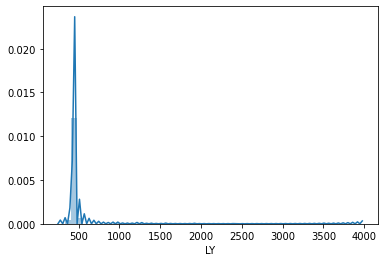

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Plot a histogram with equally spaced bins
sns.distplot(df['LY'],
             bins = 50, # try different numbers of bins
             kde=True,  # add a smooth curve using a kernel density estimate
)

plt.show()

We definitely have outliers. Our wikipedia article told us to expect 136.2±1.2 pc (parsecs). That's a variation of ±0.9%.

In [25]:
from scipy import stats

# Remove outliers and make a new dataframe
df = df[(np.abs(stats.zscore(df['LY'])) < 0.25)] # only keep data within 0.25 standard deviations from the mean, assuming a Gaussian distribution

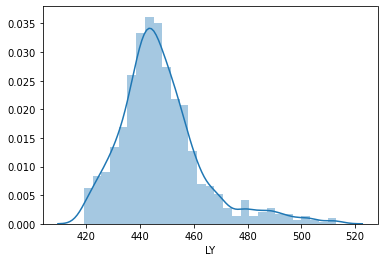

In [26]:
sns.distplot(df['LY'], kde=True)

plt.show()

In [28]:
df['LY'].describe()

count    879.000000
mean     447.642453
std       15.534001
min      419.081003
25%      438.251131
50%      445.488274
75%      454.182430
max      513.005892
Name: LY, dtype: float64

Getting better. The average is 447.6 LY. By eye, it looks like stars farther than about 470 LY still seem to be outliers. Let's chop them off and see where we stand.

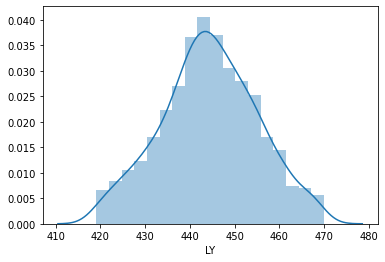

In [29]:
df = df[df['LY']<=470]
sns.distplot(df['LY'], kde=True)
plt.show()

In [30]:
df['LY'].describe()

count    810.000000
mean     444.382807
std       10.729159
min      419.081003
25%      437.655609
50%      444.164976
75%      451.569473
max      469.996044
Name: LY, dtype: float64

That's much better.

# Calculating Luminosity

Now that we have absolute magnitude (column `M`), we can solve for luminosity in terms of multiples of luminosity of the sun, or $\frac{L}{L_{☉}}$, using:
$$M = +4.77 - 2.5 \cdot log\frac{L}{L_{☉}}$$<br>
$$2.5 \cdot log\frac{L}{L_{☉}} = 4.77 - M$$<br>
$$log\frac{L}{L_{☉}} = \frac{4.77 - M}{2.5}$$<br>
$$\frac{L}{L_{☉}} = 10^{\frac{4.77 - M}{2.5}}$$<br>
from http://hosting.astro.cornell.edu/academics/courses/astro201/mag_absolute.htm

In [31]:
# add a new column ('L_sun') for luminosity in terms of multiples of solar luminosity
df['L_sun'] = np.power(10,[(4.77-m)/2.5 for m in df['M']])

In [32]:
df['L_sun'].describe()

count    810.000000
mean       1.499637
std        8.398423
min        0.000179
25%        0.002089
50%        0.006225
75%        0.077586
max      114.327997
Name: L_sun, dtype: float64

Our Gaia data already supplies luminosity (column `lum_val`) for some stars. Let's look at it. Note that `NaN`, for "not a number", appears when no data is provided.

In [33]:
df['lum_val']

16     2.300189
18     0.764250
19     8.664760
24     0.122421
25     0.086321
         ...   
967         NaN
968    0.492468
970    0.049681
971    0.648189
977    7.839014
Name: lum_val, Length: 810, dtype: float32

Let's look at just the stars that do have data (where the data is *not* null):

In [34]:
df[df['lum_val'].isnull()==False]['lum_val']

16     2.300189
18     0.764250
19     8.664760
24     0.122421
25     0.086321
         ...   
963    1.091812
968    0.492468
970    0.049681
971    0.648189
977    7.839014
Name: lum_val, Length: 262, dtype: float32

That's a shorter list! Let's get python to compute the percentage of stars that have luminosity data.

In [35]:
len_good = len(df[df['lum_val'].isnull()==False])
len_total = len(df)
print("That's", len_good, "stars with luminosity data out of", len_total, 
      f"({len_good/len_total:.1%})")

len_good = len(df[df['teff_val'].isnull()==False])
print("and looking ahead a bit, there are", len_good, "stars with temperature data out of", len_total, 
      f"({len_good/len_total:.1%})")

len_good = len(df[df['radius_val'].isnull()==False])
print("and", len_good, "with radius data out of", len_total, 
      f"({len_good/len_total:.1%})")

That's 262 stars with luminosity data out of 810 (32.3%)
and looking ahead a bit, there are 588 stars with temperature data out of 810 (72.6%)
and 262 with radius data out of 810 (32.3%)


Let's make table of stars with provided luminosity (not null values) so we can compare our computed values.

In [36]:
compare_luminosity = df.loc[df['lum_val'].isnull()==False, # the condition we want to be true
                            ['lum_val','L_sun']] # the columns that we want to put in the new table
compare_luminosity

,lum_val,L_sun
16,2.300189,2.529215
18,0.764250,0.813740
19,8.664760,9.314137
24,0.122421,0.067154
25,0.086321,0.065710
...,...,...
963,1.091812,1.138735
968,0.492468,0.488989
970,0.049681,0.023009
971,0.648189,0.637957


We can plot the values to see how they compare. Seaborn library contains a convenient linear regression function, `regplot()`, that draws a scatterplot of both columns with a regression line and shaded 95% confidence interval.

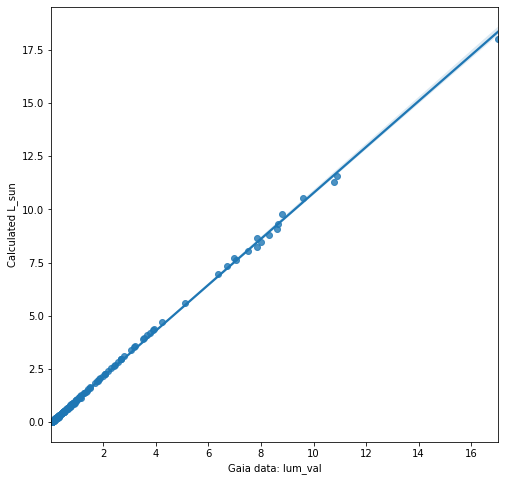

In [37]:
fig, axs = plt.subplots(nrows=1, figsize=(8,8))

compare_lum = df.loc[df['lum_val'].isnull()==False, ['lum_val','L_sun']]
lum = sns.regplot(compare_lum['lum_val'], compare_lum['L_sun'], ax=axs)
lum.set(xlabel='Gaia data: lum_val', ylabel='Calculated L_sun')

plt.show()

# Calculating effective temperature

Solving for effective temperature in Kelvin, $T_K$, using:
$$T_K = \frac{5601 K}{(\mathtt{color}+0.4)^{2/3}}$$<br>
Note that this formula breaks when $\mathtt{color} = -0.4$<br>
from http://astro.physics.uiowa.edu/ITU/labs/professional-labs/photometry-of-a-globular/part-2-finding-temperature.html

In [38]:
# check if any color values are < -0.4 or null
df[(df['bp_rp']<=-0.4) | (df['bp_rp'].isnull()==True)]

,gmag,ra,dec,plx,bp_rp,lum_val,teff_val,radius_val,M,LY,L_sun
47,9.967809,57.491181,23.847954,7.262145,NaN,NaN,NaN,NaN,4.273133,449.117965,1.580326
79,16.613859,58.047312,24.930016,7.680567,-0.430557,NaN,8868.666992,NaN,11.040826,424.650956,0.003102
152,17.550318,56.825652,24.230568,7.703831,NaN,NaN,NaN,NaN,11.983852,423.368560,0.001302
187,15.349448,57.554229,24.351824,6.994193,NaN,NaN,NaN,NaN,9.573136,466.324005,0.011988
430,11.481304,56.583196,25.475364,7.418772,NaN,NaN,NaN,NaN,5.832964,439.636114,0.375677
469,17.703762,57.320234,24.016444,6.962688,NaN,NaN,NaN,NaN,11.917647,468.434031,0.001383
483,10.112981,56.453029,23.147857,7.327235,NaN,NaN,NaN,NaN,4.437682,445.128326,1.358086
624,16.449940,57.084596,24.915198,7.145364,NaN,NaN,NaN,NaN,10.720062,456.458173,0.004168
716,19.652250,56.558642,23.365561,7.221616,NaN,NaN,NaN,NaN,13.945422,451.638555,0.000214
748,14.652494,56.825473,24.036443,7.350754,NaN,NaN,NaN,NaN,8.984154,443.704169,0.020622


In [39]:
# python trick: you can refer to the results of the previous code cell by the underscore character, "_".
# use the underscore "_" to grab the length of the above table.
length = len(_)
print("So we'll have to lose", length, "stars")

So we'll have to lose 13 stars


In [40]:
print('# of stars before:', len(df))

# of stars before: 810


In [41]:
if length > 0:
    df = df[df['bp_rp']>-0.4]
    print(length, 'stars deleted')
else:
    print('no change needed')

13 stars deleted


In [42]:
print('# of stars after:', len(df))

# of stars after: 797


In [43]:
# now we can add a new column ('T_K') for effective temperature in Kelvin
df['T_K'] = [5601/np.power(c+0.4,2/3) for c in df['bp_rp']]

In [44]:
df['T_K'].describe()

count      797.000000
mean      3285.961208
std       1479.918228
min       2141.719796
25%       2463.801873
50%       2652.148652
75%       3521.115300
max      12310.095331
Name: T_K, dtype: float64

# Calculating size

Now that we have $T_K$ and $\frac{L}{L_☉}$, we can solve for radius in multiples of solar radii, $$\frac{R}{R_☉}$$<br>
using $$\frac{R}{R_☉} = \frac{\sqrt{L/L_☉}}{(T_K/T_☉)^2}$$

In [45]:
df['R_sun']=np.around(np.sqrt(df['L_sun'])/(df['T_K']/5800)**2, decimals=2) # T_☉ = 5800

In [46]:
df['R_sun'].describe()

count    797.000000
mean       0.645809
std        0.574150
min        0.020000
25%        0.250000
50%        0.410000
75%        0.800000
max        3.110000
Name: R_sun, dtype: float64

Let's see how our calculated values for effective surface temperature in Kelvin, `T_K`, and radius in multiples of solar radius, `R_sun` compare to Gaia's data (for some stars) in columns `teff_val`, and `radius_val`.

Let's look at Gaia's effective temperature and solar radius data.

In [47]:
df['teff_val']

16     6020.866699
18     5518.000000
19     7696.000000
24     3744.693359
25     4267.000000
          ...     
967            NaN
968    5042.066895
970    3512.189941
971    5000.000000
977    7963.195312
Name: teff_val, Length: 797, dtype: float32

In [48]:
df['radius_val']

16     1.393851
18     0.956548
19     1.655773
24     0.831281
25     0.537607
         ...   
967         NaN
968    0.919654
970    0.601992
971    1.072910
977    1.470986
Name: radius_val, Length: 797, dtype: float32

As we did earlier with luminosity data, let's make tables of stars with provided non-null temperature and radius values and draw regression plots so we can compare our computed values.

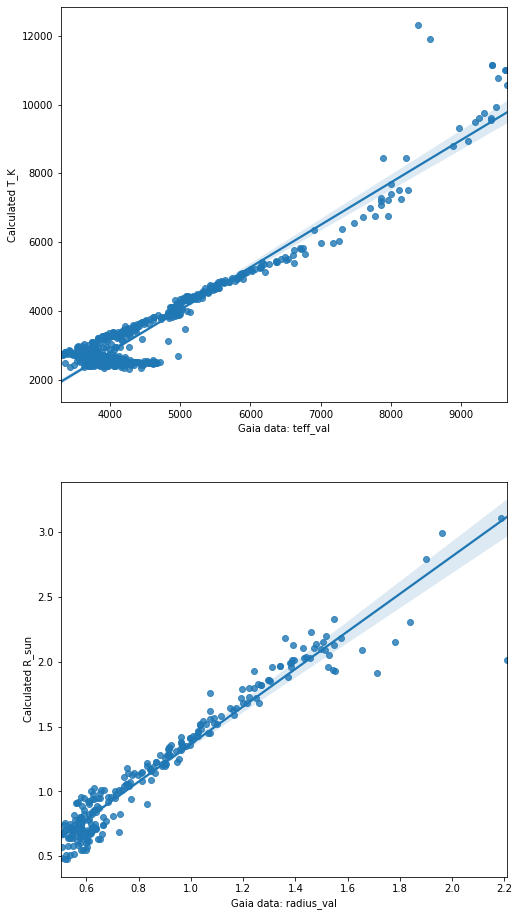

In [49]:
fig, axs = plt.subplots(nrows=2, figsize=(8,16))

compare_temp = df.loc[df['teff_val'].isnull()==False, ['teff_val', 'T_K']]
temp = sns.regplot(compare_temp['teff_val'], compare_temp['T_K'], ax=axs[0])
temp.set(xlabel='Gaia data: teff_val', ylabel='Calculated T_K')

compare_rad = df.loc[df['radius_val'].isnull()==False, ['radius_val', 'R_sun']]
rad = sns.regplot(compare_rad['radius_val'], compare_rad['R_sun'], ax=axs[1])
rad.set(xlabel='Gaia data: radius_val', ylabel='Calculated R_sun')

plt.show()

# Plotting position in the night sky

Let's plot right ascension and declination for our cluster and display brighter stars with larger dots and more vibrant colors.

We can't use apparent brightness, `'gmag'`, directly to show brighter stars with larger dots and brighter colors because magnitude is a scale with an "inverted" sense (dimmer stars have larger values). Let's reverse the values just for this plot. 

In [50]:
# subtract apparent brightness ('gmag') from the largest value to give the brightest stars large values and the dimmest stars small ones (the opposite of the apparent magnitude scale)
brightness = df['gmag'].max()-df['gmag']
brightness.name = 'brightness'
brightness.describe()

count    797.000000
mean       4.881563
std        3.054618
min        0.000000
25%        2.664265
50%        3.814735
75%        6.598544
max       14.583029
Name: brightness, dtype: float64

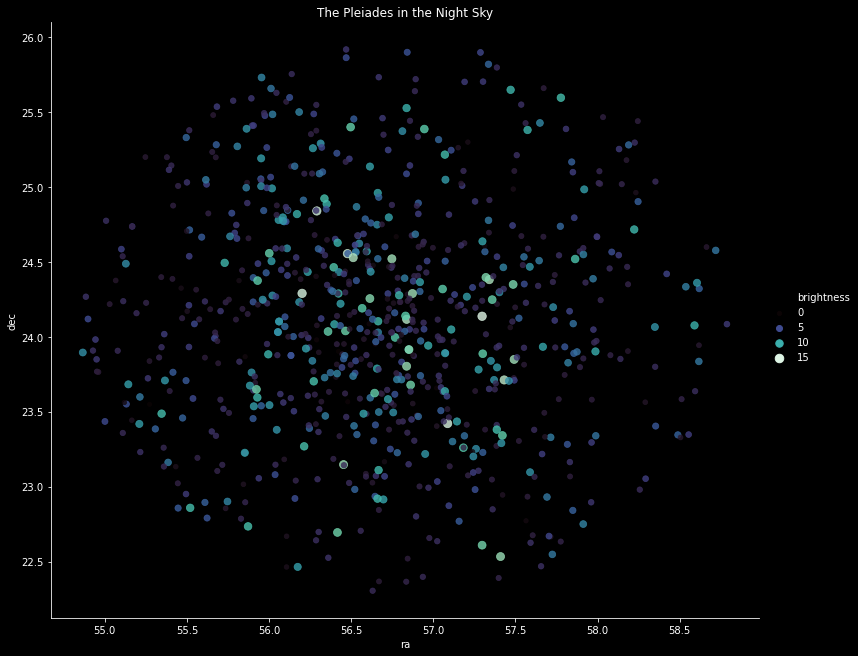

In [51]:
plt.style.use('dark_background')
sns.relplot(x='ra', y='dec', height=9, aspect=1.2, alpha=0.8, edgecolor=None,
                size=brightness,
                hue=brightness,
                palette='mako', 
                data=df, 
               )
plt.title('The Pleiades in the Night Sky')

plt.show()

# HR Diagram

Let's plot color vs. absolute magnitude.

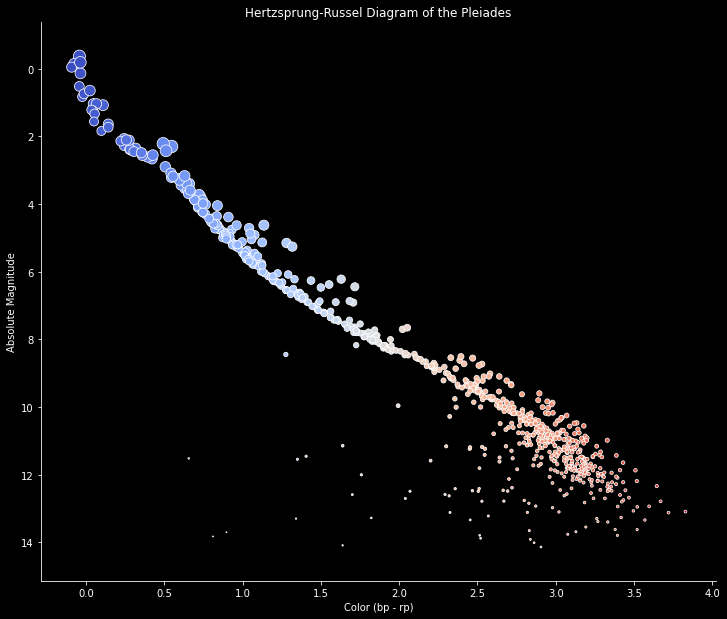

In [52]:
sns.relplot(x='bp_rp', y='M', height=8.5, aspect=1.2, legend=None,
            #edgecolor=None,
            hue='bp_rp',
            palette='coolwarm',
            size='R_sun',
            sizes=(1,df['R_sun'].max()/df['R_sun'].min()),
            data=df
            )
plt.ylim(df['M'].max()+1, df['M'].min()-1)
plt.xlabel('Color (bp - rp)')
plt.ylabel('Absolute Magnitude')
plt.title('Hertzsprung-Russel Diagram of the Pleiades')

plt.show()

Now go look up the Hyades star cluster and
* plot ra/dec--remember to:
    * invert apparant magnitude (column `'gmag'`) for the plot
    * apply a "reasonableness test" to your distances and clean outliers
* make an HR diagram--note that you'll need to:
    * calculate absolute magnitude
    * calculate radius and
    * "clean" the data by getting rid of stars with null color data (column `'bp_rp'`)


<img src="https://www.constellation-guide.com/wp-content/uploads/2012/10/Hyades.jpg" width=800 />

Image credit: taken December 20, 2006 at 7:36pm EST by Todd Vance